<a href="https://colab.research.google.com/github/manavkdubey/fashion-mnist/blob/main/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST
### This is a python notebook to detect fashion clothings from their image
### We will use classification to categorize the different images we recive and towards the end export out our model to use it to identify custom images

In [153]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import gzip
from PIL import Image
import pandas as pd

In [154]:
tf.__version__

'2.13.0'

In [155]:

def load_mnist(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic = int.from_bytes(f.read(4), byteorder='big')
        num_images = int.from_bytes(f.read(4), byteorder='big')
        num_rows = int.from_bytes(f.read(4), byteorder='big')
        num_cols = int.from_bytes(f.read(4), byteorder='big')

        # Read the image data
        data = np.fromfile(f, dtype=np.uint8)
        data = data.reshape(num_images, num_rows, num_cols)

    return data

In [156]:
tempx= load_mnist("/content/drive/MyDrive/data/fashion/train-images-idx3-ubyte")

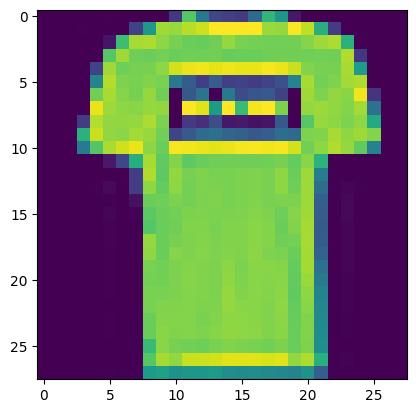

In [157]:
plt.imshow(tempx[1])

In [158]:
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic = int.from_bytes(f.read(4), byteorder='big')
        num_labels = int.from_bytes(f.read(4), byteorder='big')

        # Read the label data
        label_data = np.fromfile(f, dtype=np.uint8)

    return label_data

In [159]:
labels_index=load_mnist_labels("/content/drive/MyDrive/data/fashion/train-labels-idx1-ubyte")
df=pd.read_csv("/content/drive/MyDrive/data/fashion/fashion-mnist_train.csv")

In [160]:
unique_labels_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
unique_labels=np.array(unique_labels_list)
labels_index

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [161]:
labels = []
for label_index in labels_index:
    label = unique_labels[label_index]
    labels.append(label)

In [162]:
labels[1]==unique_labels

array([ True, False, False, False, False, False, False, False, False,
       False])

In [163]:
tempx_test=load_mnist("/content/drive/MyDrive/data/fashion/t10k-images-idx3-ubyte")

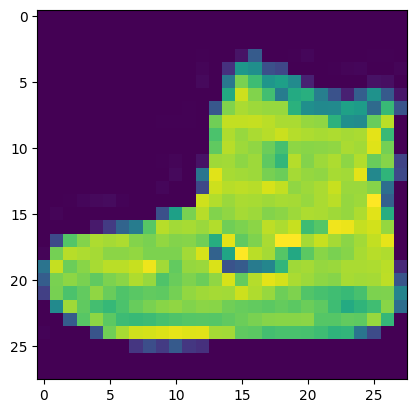

In [164]:
plt.imshow(tempx[0])

In [165]:
labels_test=load_mnist_labels("/content/drive/MyDrive/data/fashion/t10k-labels-idx1-ubyte")
labels_test[0]


9

In [166]:
x_color = np.zeros((tempx.shape[0], tempx.shape[1], tempx.shape[2], 3), dtype=np.uint8)
x_color[..., 0] = tempx
x_color[..., 1] = tempx
x_color[..., 2] = tempx
x= x_color

In [167]:
boolean_labels=[label== unique_labels for label in labels]
y=boolean_labels
y[0]

array([False, False, False, False, False, False, False, False, False,
        True])

In [168]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=42)

len(x_train),len(x_val),len(y_train),len(y_val)

(48000, 12000, 48000, 12000)

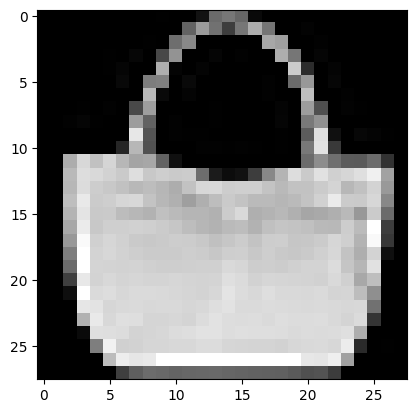

In [169]:
plt.imshow(x[100])

In [170]:

def process_image(image):
  return image

In [171]:
def get_image_label(image,label):
  return image,label



In [172]:
y_train[0]

array([False, False, False, False, False, False, False,  True, False,
       False])

In [173]:
BATCH_SIZE=32

def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  if test_data:
    print("Creating test data batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch= data.batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("Creating validation data batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                             tf.constant(y)))
    data_batch= data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creating training data batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                             tf.constant(y)))
    data=data.shuffle(buffer_size=len(x))
    data_batch= data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [174]:
train_data=create_data_batches(x_train,y_train)
val_data=create_data_batches(x_val,y_val,valid_data=True)


Creating training data batches...
Creating validation data batches...


In [175]:
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 28, 28, 3), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 28, 28, 3), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)))

In [176]:
import matplotlib.pyplot as plt
def show_25_image(images,labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_labels[labels[i].argmax()])
    plt.axis("off")

In [177]:
train_images,train_labels =next(train_data.as_numpy_iterator())
len(train_images),len(train_labels)


(32, 32)

In [178]:
train_labels[0]

array([False, False, False, False,  True, False, False, False, False,
       False])

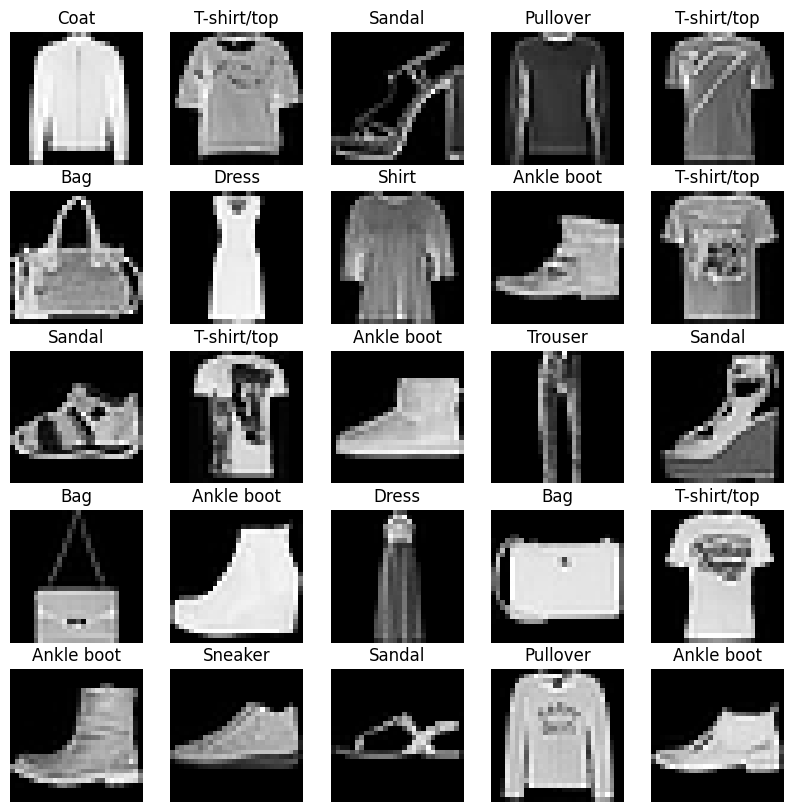

In [179]:
show_25_image(train_images,train_labels)

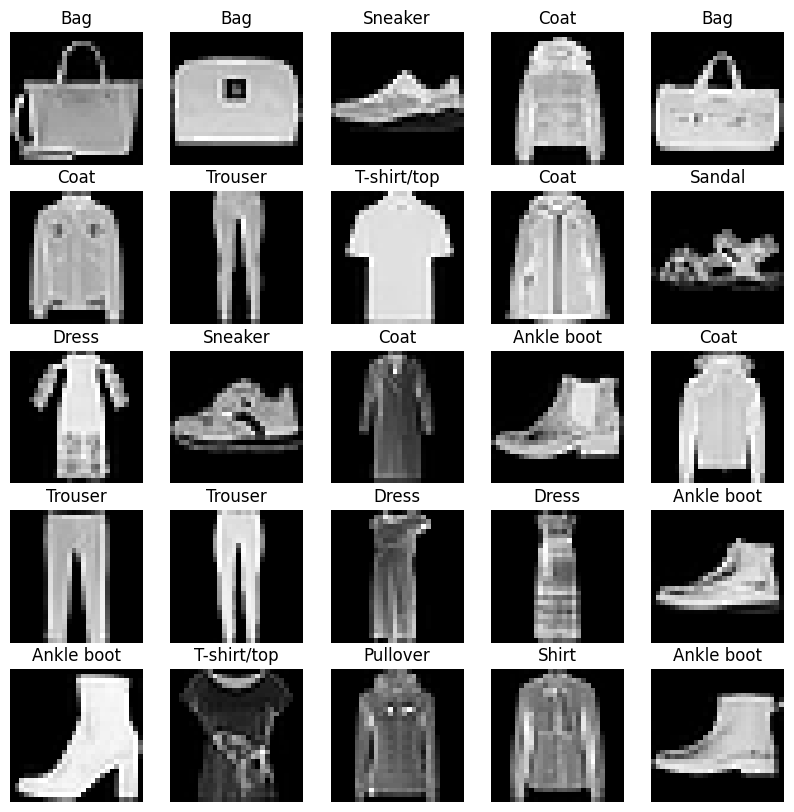

In [180]:
val_images,val_labels =next(val_data.as_numpy_iterator())
len(val_images),len(val_labels)
show_25_image(val_images,val_labels)

In [181]:
INPUT_SHAPE = [None,28,28,3]

OUTPUT_SHAPE=10
# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [191]:

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL, trainable=False),
        tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax")
    ])

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model
def create_normal_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')])

    # Compile the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])

    return model

In [192]:
model2=create_normal_model()
model2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dense_26 (Dense)            (None, 128)             

In [184]:
model=create_model()
model.summary()

Building model with: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_17 (KerasLayer  (None, 1280)              4049564   
 )                                                               
                                                                 
 dense_23 (Dense)            (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [185]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [186]:
import datetime
import os
def create_tensorboard_callback():
  logdir= os.path.join("/content/drive/MyDrive/colab/logs",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [187]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3)

## Training our model

In [188]:
NUM_EPOCHS= 10 #@param{type:"slider",min:1,max:100,step:10}

In [189]:
def train_model():
  model = create_model()

  tensorboard=create_tensorboard_callback()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  return model

def train_model2():
  model = create_normal_model()

  tensorboard=create_tensorboard_callback()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            batch_size=32,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  return model

In [193]:
model = train_model2()

Epoch 1/10
1500/1500 [==============================] - 13s 6ms/step - loss: 0.7707 - accuracy: 0.7897 - val_loss: 0.3819 - val_accuracy: 0.8577
Epoch 2/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4081 - accuracy: 0.8501 - val_loss: 0.3638 - val_accuracy: 0.8703
Epoch 3/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3715 - accuracy: 0.8631 - val_loss: 0.3459 - val_accuracy: 0.8749
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3469 - accuracy: 0.8716 - val_loss: 0.3305 - val_accuracy: 0.8772
Epoch 5/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3269 - accuracy: 0.8768 - val_loss: 0.3316 - val_accuracy: 0.8802
Epoch 6/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3165 - accuracy: 0.8832 - val_loss: 0.3226 - val_accuracy: 0.8833
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2984 - accuracy: 0.8875 - val_loss: 0.3057 - val_accura